![House](![House](file:///E:/phase%204%20project/phase-4-group-project/images/house.jpg))




# TIME SERIES FOR PREDICTING HOUSE PRICES 
### Authors 
* Emily Njue 
* Nelson Kibet Kemboi 
* Brian Muli 
* Joel Omondi 
* Ian Tulienge 
* Lavender Echesa 


In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
#loading the dataset 
data = pd.read_csv('zillow_data.csv')
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
#checking columns
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

In [4]:
# A function to print the shape of our datasets
def print_dataset_shape(*datasets):
    """
    Prints the shape of one or more datasets (number of rows and columns).
    Assumes datasets are in a Pandas DataFrame format.
    """
    for idx, dataset in enumerate(datasets):
        print(f"Dataset {idx + 1} - Number of rows: {dataset.shape[0]}")
        print(f"Dataset {idx + 1} - Number of columns: {dataset.shape[1]}")
# print the shape of our dataset
print_dataset_shape(data)

Dataset 1 - Number of rows: 14723
Dataset 1 - Number of columns: 272


In [5]:
#getting the info of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Data Preprocessing

In [6]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

out of top 50 sizerank:
* find top 5 ROI value today / value original * zip codes
* forecast 3 year investment horizon for each zipcode
* refine model
* choose best zipcode to invest

In [7]:
#select top 50 sized zipcodes according to sizerank
top_50_size = data.iloc[:50]
top_50_size

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500


In [8]:
#calculate ROI for each zip code
top_50_size['ROI'] = (top_50_size['2018-04'] / top_50_size['1996-04']) - 1
top_50_size.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,2.083782
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,0.365295
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,0.567966
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,1.623971
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,0.571798


In [9]:
#select 10 largest ROI
top_50_size['ROI'].nlargest(n=10)

29    6.330859
33    5.030201
10    4.945679
30    4.774809
47    4.195133
9     3.978460
46    3.323709
12    3.297147
13    3.284514
15    3.040656
Name: ROI, dtype: float64

In [10]:
top5 = top_50_size.iloc[[29, 33, 10, 30, 47]]
top5

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
29,66126,20002,Washington,DC,Washington,District of Columbia,30,94300.0,94000.0,93700.0,...,668000,672200,673100,674600,678200,680900,683000,687500,691300,6.330859
33,66133,20009,Washington,DC,Washington,District of Columbia,34,178800.0,179200.0,179600.0,...,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200,5.030201
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,4.945679
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900,4.774809
47,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400,4.195133


* Once we have calculated the return on investment (ROI) for various zip codes over a historical period, we can identify the top five zip codes with the highest returns. We will now focus our analysis on these five zip codes and make projections for the next three years into the future.

# DATA PREPROCESSING
* We changed our data from wide range to long format for easier analysis 

In [11]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [12]:
#melt data to reformat
melted_data = melt_data(top5)
melted_data.head()

,value
time,
1996-04-01,201160.0
1996-05-01,201600.0
1996-06-01,202080.0
1996-07-01,202620.0
1996-08-01,203200.0


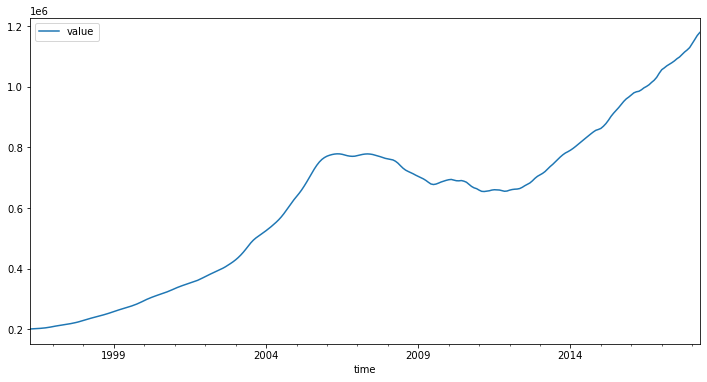

In [13]:
#ploting our melted data 
melted_data.plot(figsize=(12,6));

* The data reveals a consistent upward trend in housing prices for the selected zip codes. However, there are also cyclical fluctuations that align with the broader business cycle, including periods of recession such as the `post-2008 lows` and subsequent periods of growth.

* In recent years, there has been a notable surge in housing prices, which can be attributed to two main factors: unprecedented supply shortages and historically low interest rates. These factors have created a significant demand-supply imbalance, driving up prices and leading to a breakout in the housing market.

In [14]:
#separate each region
Washington_20002 = top5.iloc[[0]]
Washington_20009 = top5.iloc[[1]]
NewYork_11226 = top5.iloc[[2]]
LosAngeles_90046 = top5.iloc[[3]]
NewYork_11230= top5.iloc[[4]]


In [15]:
#melting top five regions 
melted_r1 = melt_data(Washington_20002)
melted_r2 = melt_data(Washington_20009)
melted_r3 = melt_data(NewYork_11226)
melted_r4 = melt_data(NewYork_11230)
melted_r5 = melt_data(LosAngeles_90046)


In [16]:
#defining a function to visualize tiem series for top 5 regions 
def melt_and_visualize_regions(regions):
    region_names = ["Washington_20002", "Washington_20009", "NewYork_11226", "LosAngeles_90046", "NewYork_11230"]
    num_regions = len(regions)
    fig, ax = plt.subplots(figsize=(15, 8))
    
    for i, region in enumerate(regions):
        melted_data = melt_data(region)
        ax.plot(melted_data)
    
    ax.legend(region_names[:num_regions])
    
    title_mapping = {
        1: "Washington_20002",
        2: "Washington_20009",
        3: "NewYork_11226",
        4: "LosAngeles_90046",
        5: "NewYork_11230"
    }
    title = title_mapping.get(num_regions, "Time Series Data for Multiple Regions")
    ax.set_title(title)
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    
    plt.show()

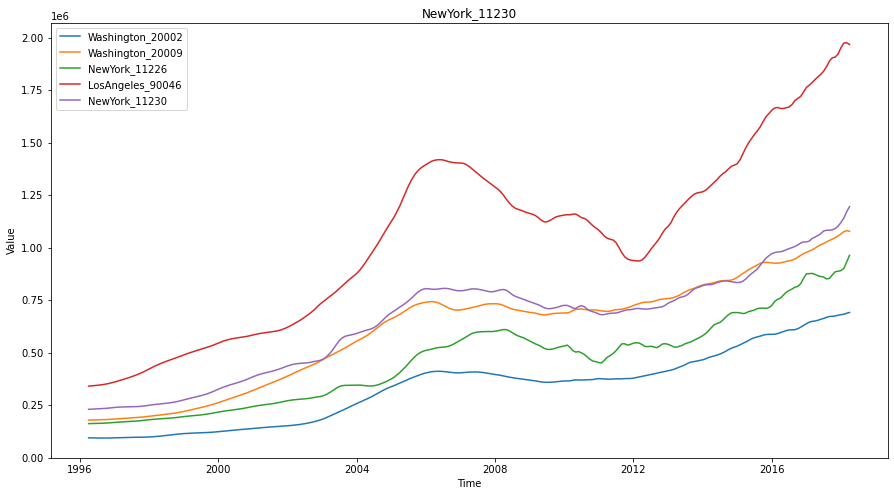

In [17]:
#calling the function to plot the graph
regions = [Washington_20002, Washington_20009, NewYork_11226, LosAngeles_90046, NewYork_11230]
melt_and_visualize_regions(regions)


* In each of the regions `"Washington_20002", "Washington_20009", "NewYork_11226", "LosAngeles_90046", "NewYork_11230"`, we can observe the boom and bust cycle that was previously discussed. The boom and bust cycle refers to the pattern of economic growth followed by a period of decline or recession.

* Some regions fared better than others in weathering the post-2008 lows. This can be seen by comparing the depth of the trough, which represents the lowest point in the economic cycle. Regions that experienced a lower trough were more resilient and recovered faster from the economic downturn.

* However, despite the variations in the severity of the bust cycle, all regions have shown an overall upward trend in recent years. This indicates that the economy in each region has been recovering and growing steadily. The upward trend suggests positive economic conditions and reflects the resilience and strength of these regions in bouncing back from the previous recession.

# EDA AND VISUALIZATION

In [18]:
melted_data

,value
time,
1996-04-01,201160.0
1996-05-01,201600.0
1996-06-01,202080.0
1996-07-01,202620.0
1996-08-01,203200.0
...,...
2017-12-01,1129180.0
2018-01-01,1141980.0
2018-02-01,1155440.0


### Time Series

* In order to prepare the data for the modeling process, we decided to drop the columns that would not be necessary for the modeling process and remain with the pricipal feature(time) together with the target feature(value).

* We are also going to format the time index column to represent a different frequency, that is, months. This is done to try and reduce the number or row entries in the datset.

* Time series data is observed at different points in time and can be used to forecast future values based on past observations. ARIMA (AutoRegressive Integrated Moving Average) is a commonly used model for time series forecasting. It incorporates parameters like p (auto-regressive), d (integrated), and q (moving average) to capture seasonality, trend, and noise in the data. If the time series has a seasonal component, a seasonal ARIMA model (SARIMA) is used with additional parameters P, D, and Q.

## STATIONERITY 

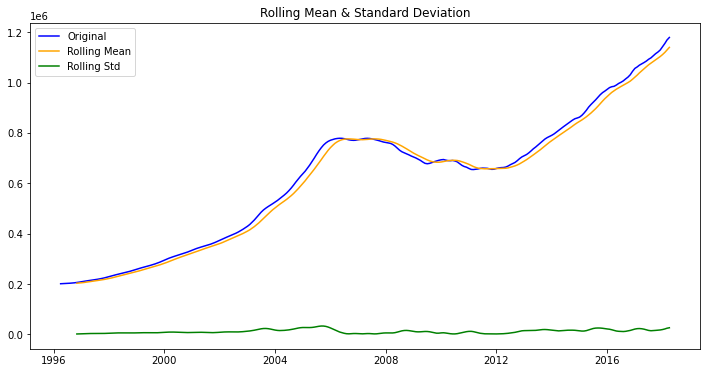

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


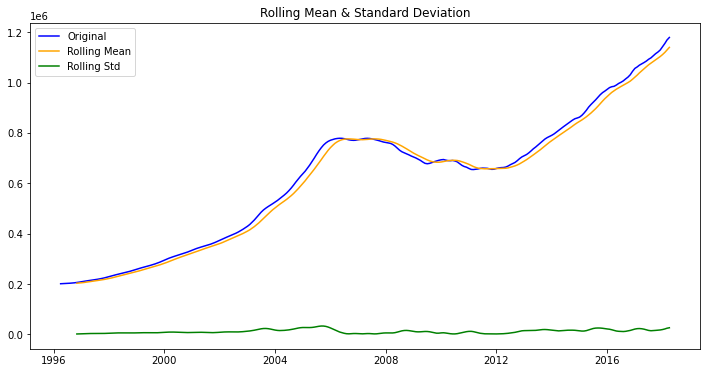

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


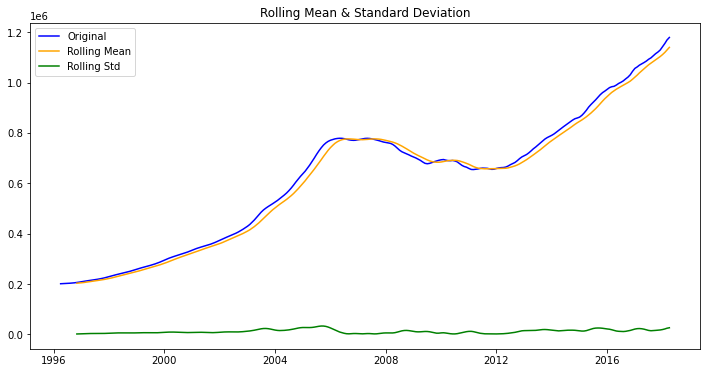

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


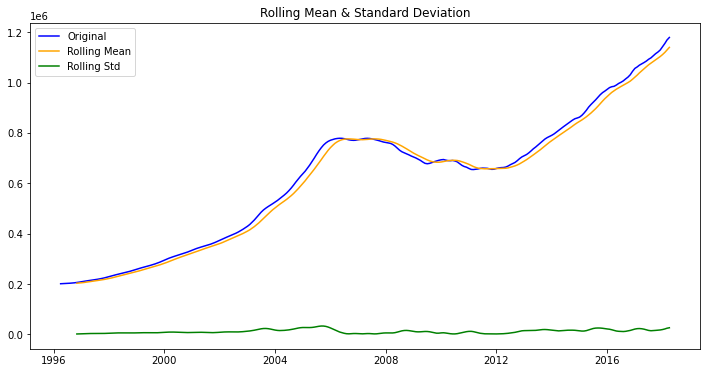

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


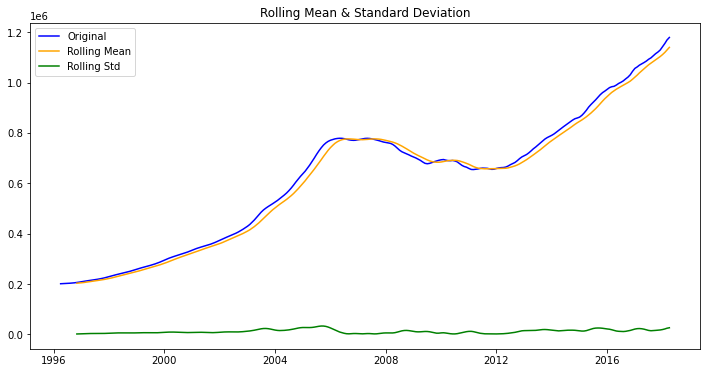

Results of Dickey-Fuller Test: 

Test Statistic                  -0.430282
p-value                          0.904919
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64

The time series is likely non-stationary.


In [19]:
def stationarity_check(TS):
    # Calculate rolling statistics
    roll_mean = melted_data.rolling(window=8, center=False).mean()
    roll_std = melted_data.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(melted_data) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(melted_data, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='orange', label='Rolling Mean')
    std = plt.plot(roll_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    # Extract the test statistic and p-value from the result
    test_statistic = dftest[0]
    p_value = dftest[1]
    
    # Check if the time series is stationary based on the p-value
    if p_value <= 0.05:
        print("\nThe time series is likely stationary.")
    else:
        print("\nThe time series is likely non-stationary.")
    
    return None

# Check stationarity for Washington_20002
stationarity_check(Washington_20002)

# Check stationarity for Washington_20009
stationarity_check(Washington_20009)

# Check stationarity for LosAngeles_90046
stationarity_check(LosAngeles_90046)

# Check stationarity for NewYork_11226
stationarity_check(NewYork_11226)

# Check stationarity for ewYork_11230
stationarity_check(NewYork_11230)

* The Dickey-Fuller test results indicate that none of the time series pass the test, suggesting that they are all non-stationary. In order to apply forecasting models, such as ARIMA, it will be necessary to apply differencing and/or incorporate moving average terms to make the series stationary.

* To gain further insights into the individual time series and their underlying components, we can utilize the seasonal_decompose function. This function helps visualize the decomposition of the time series into its trend, seasonality, and residual components. By examining these components, we can better understand the patterns and fluctuations within the data.

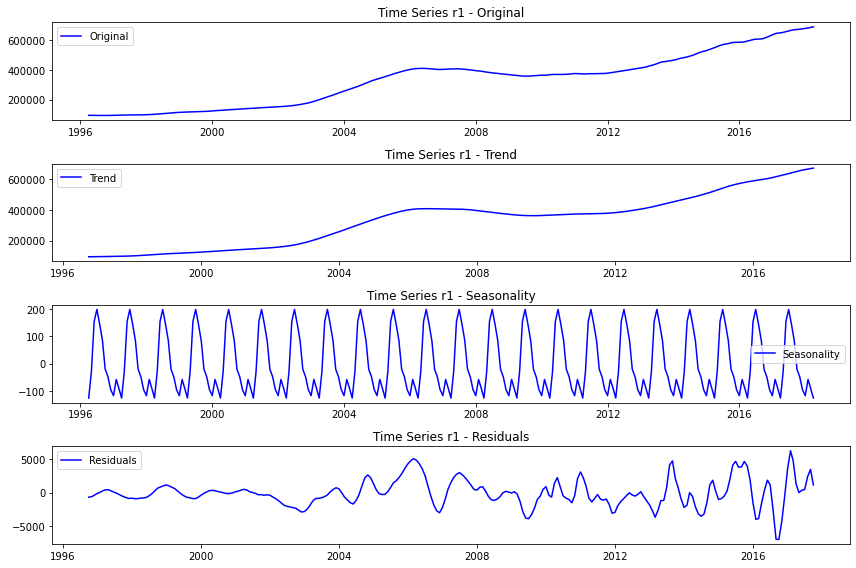

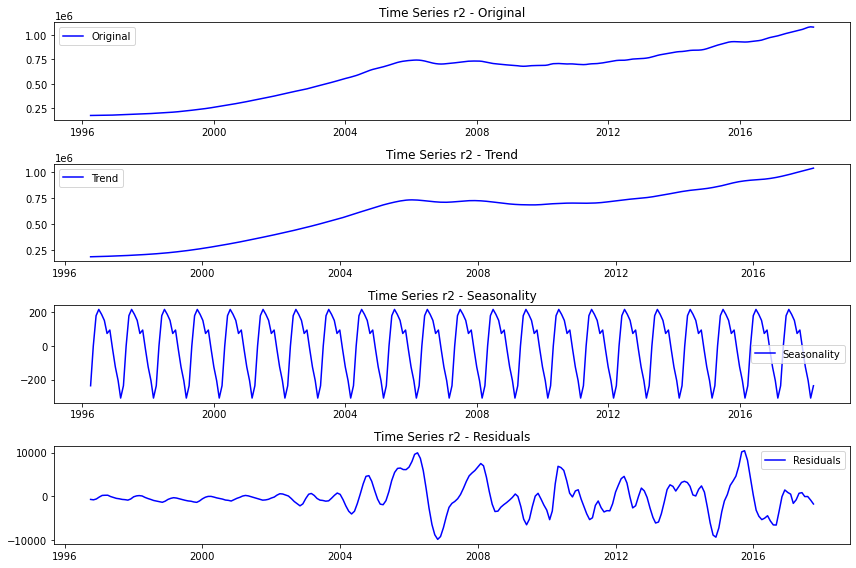

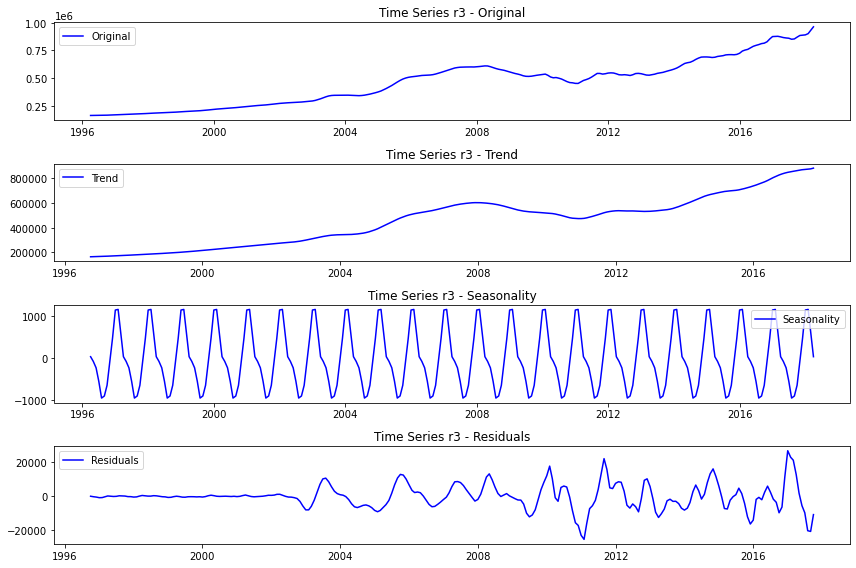

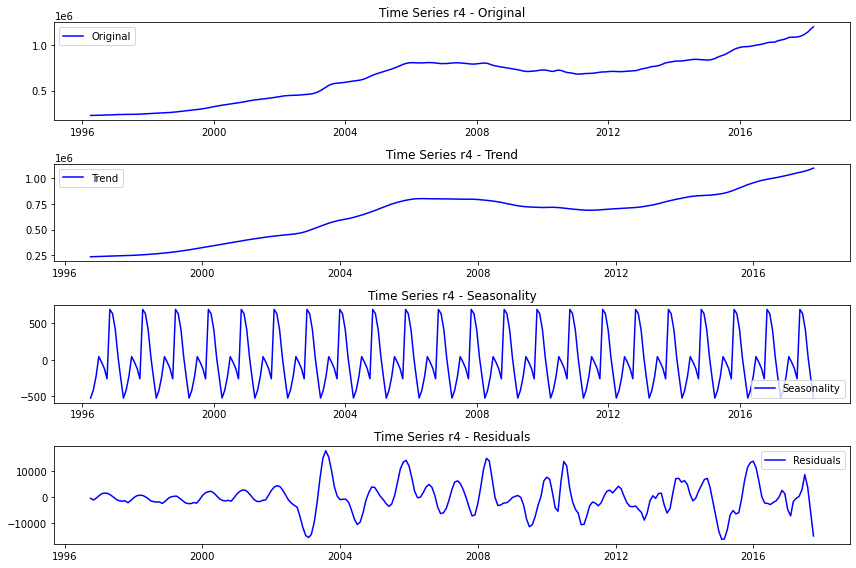

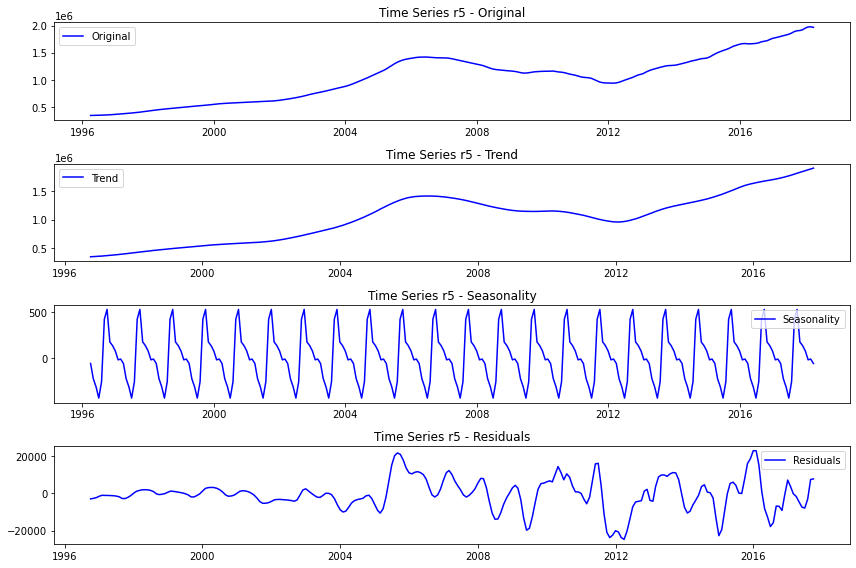

In [20]:
# Define a function for decomposition and plotting
def decompose_and_plot(time_series, title):
    decomposition = seasonal_decompose(time_series)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(time_series, label='Original', color='blue')
    plt.legend(loc='best')
    plt.title(f"{title} - Original")
    
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.title(f"{title} - Trend")
    
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.title(f"{title} - Seasonality")
    
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.title(f"{title} - Residuals")
    
    plt.tight_layout()

# Time series r1
decompose_and_plot(melted_r1, "Time Series r1")

# Time series r2
decompose_and_plot(melted_r2, "Time Series r2")

# Time series r3
decompose_and_plot(melted_r3, "Time Series r3")

# Time series r4
decompose_and_plot(melted_r4, "Time Series r4")

# Time series r5
decompose_and_plot(melted_r5, "Time Series r5")

plt.show()


* All regions, including `Washington_20002`, `Washington_20009`, `NewYork_11226`, `LosAngeles_90046`, and `NewYork_11230`, demonstrate a consistent upward trend in their respective time series data. Furthermore, these regions exhibit evidence of seasonality, which manifests on an annual basis. To effectively address the combined trend and seasonality components present in the data, we will employ the autoarima package. This powerful tool automatically selects the optimal parameters for an ARIMA model, considering both the trend and seasonal patterns within the data. By leveraging the capabilities of autoarima, we can develop accurate and robust forecasting models for these regions.

In [21]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data):
    fig, ax = plt.subplots(figsize=(16, 3))
    plot_acf(data, ax=ax, lags=40)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(16, 3))
    plot_pacf(data, ax=ax, lags=40)
    plt.show()

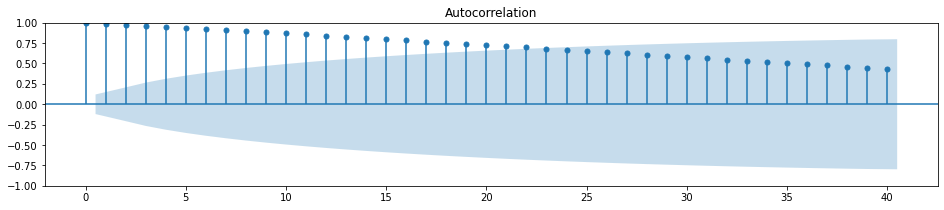

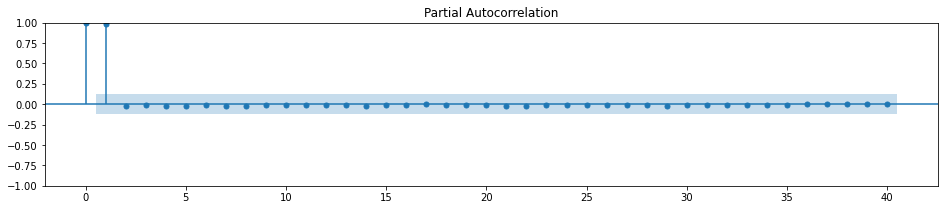

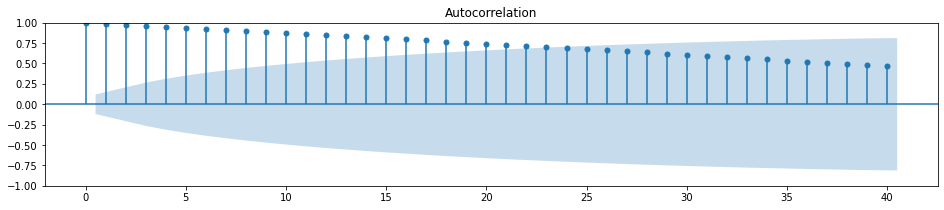

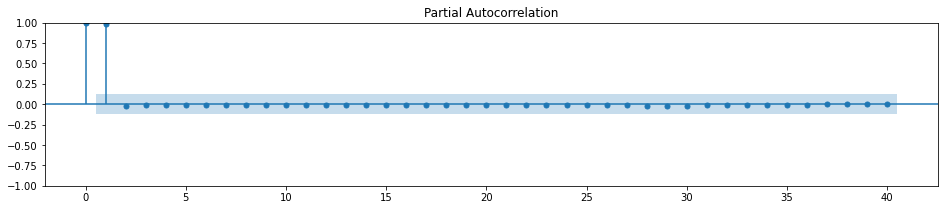

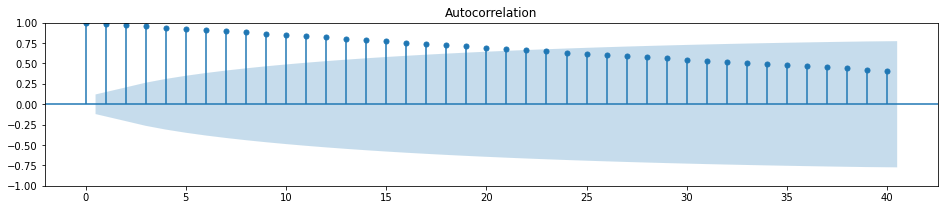

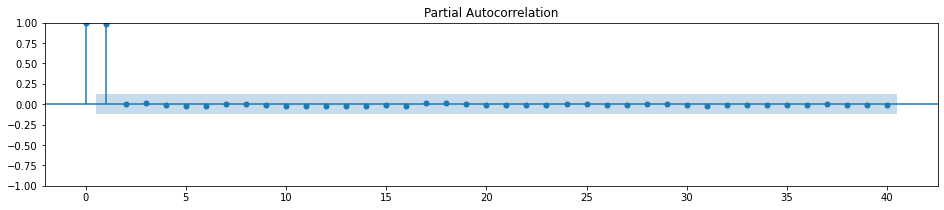

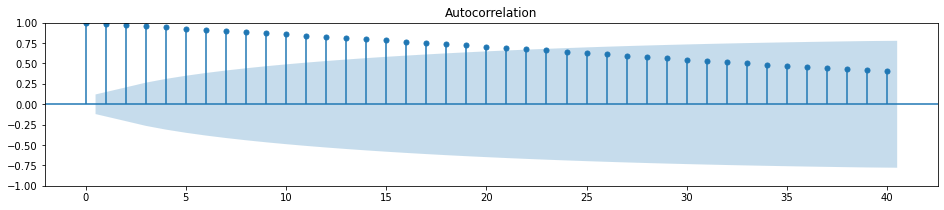

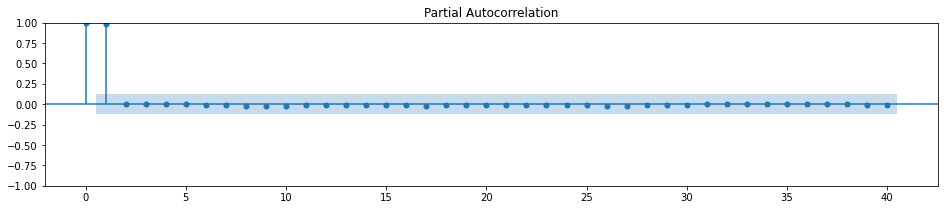

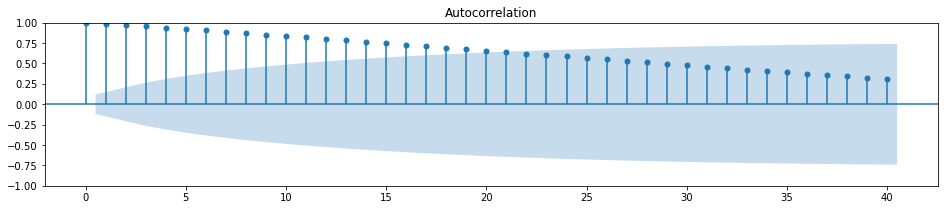

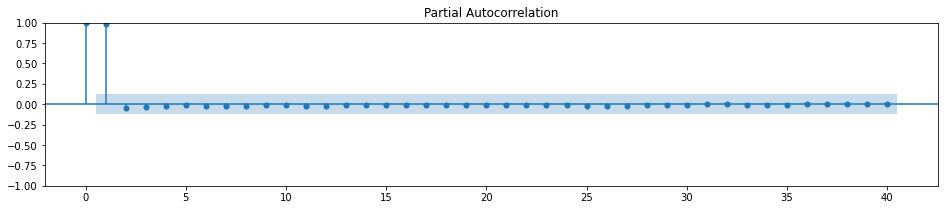

In [22]:
plot_acf_pacf(melted_r1)
plot_acf_pacf(melted_r2)
plot_acf_pacf(melted_r3)
plot_acf_pacf(melted_r4)
plot_acf_pacf(melted_r5)

The ACF and PACF plots show that both the autocorrelation and partial autocorrelation coefficients tail off, which suggests the presence of both autoregressive (AR) and moving average (MA) components in the data. This indicates that an ARMA model, which combines both AR and MA parameters, would be suitable for modeling the data.

To determine the best parameters for the ARMA model, you can use the AutoArima package. This package performs an exhaustive stepwise search, evaluating different combinations of AR and MA parameters, to find the model with the best fit to the data. By using AutoArima, you can automate the process of selecting the optimal ARMA parameters and obtain a more accurate and reliable model for your data.

## ARIMA MODELLING

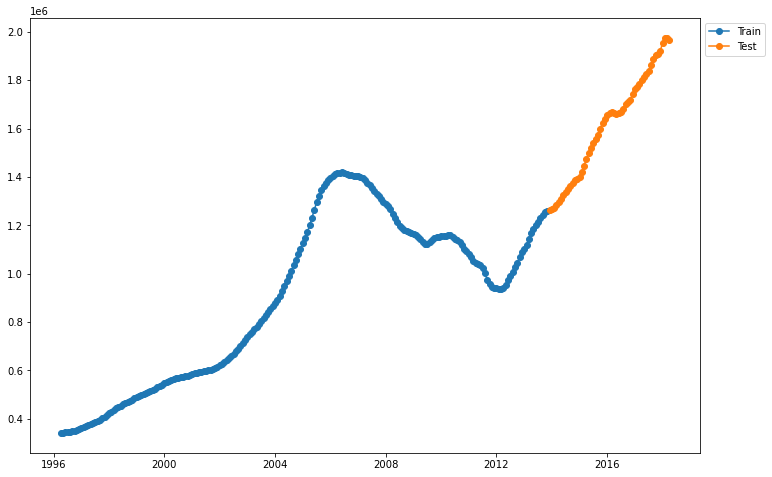

In [23]:
from pmdarima.arima import auto_arima
# Train Test Split Index
train_size = 0.8
split_idx = round(len(melted_r5)* train_size)
split_idx

# Split
r5_train = melted_r5.iloc[:split_idx]
r5_test = melted_r5.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(r5_train, label='Train', **kws)
plt.plot(r5_test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

The AutoArima package performs a stepwise search to find the best parameters for an ARMA model based on the Akaike Information Criterion (AIC). It evaluates various combinations of AR and MA parameters, calculating the AIC for each model. The model with the lowest AIC is selected as the best-fit model. This approach balances model complexity and goodness of fit, avoiding overfitting or underfitting. The resulting model is considered the best based on AIC and can be used for analysis and forecasting.

In [24]:
#stepwise search of best parameters according to AIC
r5_autoarima = auto_arima(r5_train, start_p=0, start_q=0, d=None,
                          information_criterion='aic', max_d=3, max_q=3,
                          max_p=3, start_P=0, start_Q=0, D=None, max_P=3, max_Q=3,
                          max_D=3, trace=True, stepwise=True 
                          
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4523.203, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4489.163, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4496.433, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4552.877, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4482.308, Time=0.85 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4471.360, Time=0.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4443.248, Time=0.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4442.197, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4440.468, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4454.546, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4482.520, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7183.347, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4439.355, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4519.564, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]          

In [25]:
#printing results of our model
r5_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2216.677
Date:                Wed, 21 Jun 2023   AIC                           4439.355
Time:                        18:00:37   BIC                           4449.410
Sample:                    04-01-1996   HQIC                          4443.419
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9066      0.021     42.843      0.000       0.865       0.948
ma.L1         -0.8233      0.027    -30.559      0.000      -0.876      -0.771
sigma2       7.76e+07   3.93e-11   1.98e+18      0.000    7.76e+07    7.76e+07
===================================================================================
Ljung-Box (L1) (Q):                 174.64   Jarque-Bera (JB):                45.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                            -0.61
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.62e+34. Standard errors may be unstable.
"""

Based on the results of the AutoArima model search, the selected model with parameters (1, 1, 1) and a reduced AIC value of 4439.355 appears to be a good fit for the data. The coefficient estimates for the AR(1) and MA(1) terms are statistically significant, indicating that both autoregressive and moving average components are important in capturing the underlying patterns in the data

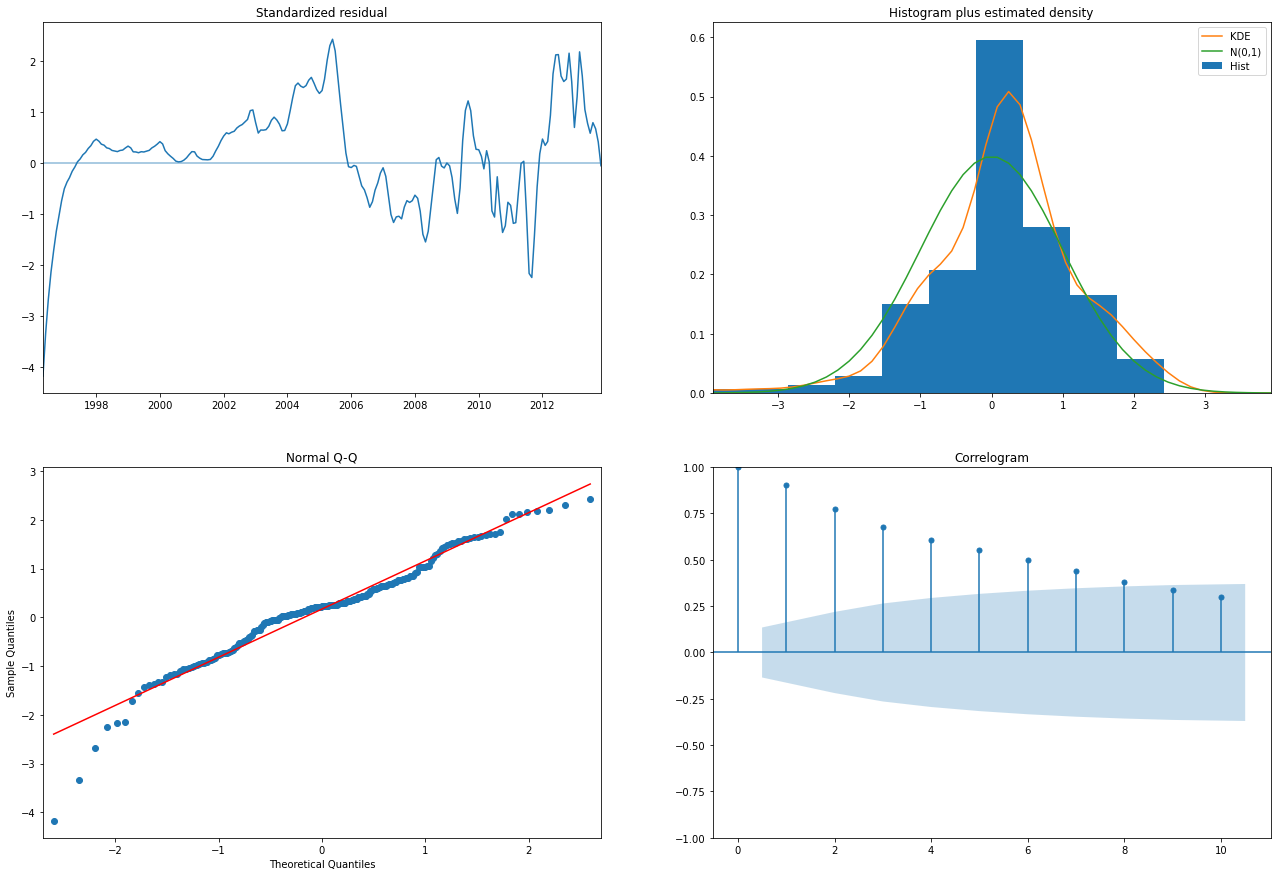

In [26]:
#visulaize model
r5_autoarima.plot_diagnostics(figsize=(22,15))
plt.show()

The kernel density estimate (KDE) of the residuals shows a distribution that resembles a normal distribution. This suggests that the residuals, which represent the differences between the observed values and the model's predictions, do not deviate significantly from a symmetric pattern.

Furthermore, when examining the residuals, there is evidence to suggest that the assumption of homoscedasticity is met. Homoscedasticity refers to the assumption that the variability of the residuals is constant across all levels of the predictor variables. In this case, the residuals exhibit a consistent spread or dispersion across the range of the predictor variables, indicating that the assumption of homogeneity of variances is satisfied.

Overall, these findings indicate that the model's residuals display characteristics of normality and homoscedasticity, suggesting that the model adequately captures the variability in the data.

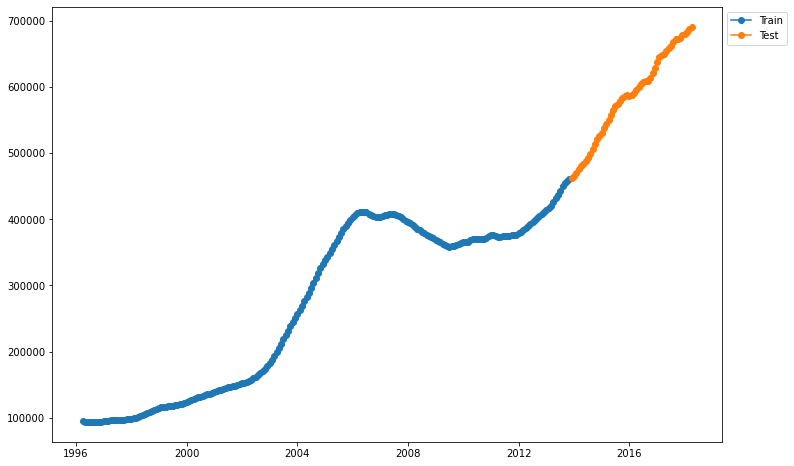

In [27]:
# Train Test Split Index
train_size = 0.8
split_idx = round(len(melted_r1)* train_size)
split_idx

# Split
r1_train = melted_r1.iloc[:split_idx]
r1_test = melted_r1.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(r1_train, label='Train', **kws)
plt.plot(r1_test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [28]:
#stepwise search of best parameters according to AIC
r1_autoarima = auto_arima(r1_train, start_p=0, start_q=0, d=None,
                          information_criterion='aic', max_d=3, max_q=3,
                          max_p=3, start_P=0, start_Q=0, D=None, max_P=3, max_Q=3,
                          max_D=3, trace=True, stepwise=True 
                          
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3922.435, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3893.215, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3900.061, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3997.673, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3877.497, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3881.597, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3838.219, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3836.345, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3838.226, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3889.031, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4457.862, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3847.653, Time=0.33 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.521 seconds


In [29]:

r1_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1914.173
Date:                Wed, 21 Jun 2023   AIC                           3836.345
Time:                        18:00:44   BIC                           3849.752
Sample:                    04-01-1996   HQIC                          3841.765
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    180.4187     60.622      2.976      0.003      61.601     299.236
ar.L1          0.8814      0.023     38.046      0.000       0.836       0.927
ma.L1         -0.7961      0.027    -29.696      0.000      -0.849      -0.744
sigma2      3.909e+06      0.001   6.43e+09      0.000    3.91e+06    3.91e+06
===================================================================================
Ljung-Box (L1) (Q):                 170.93   Jarque-Bera (JB):                63.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.60
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.31e+25. Standard errors may be unstable.
"""

Based on the results of the AutoArima model search, the selected model with parameters (1, 1, 1) and a reduced AIC value of 3836.345 appears to be a good fit for the data. The coefficient estimates for the AR(1) and MA(1) terms are statistically significant, indicating that both autoregressive and moving average components are important in capturing the underlying patterns in the data

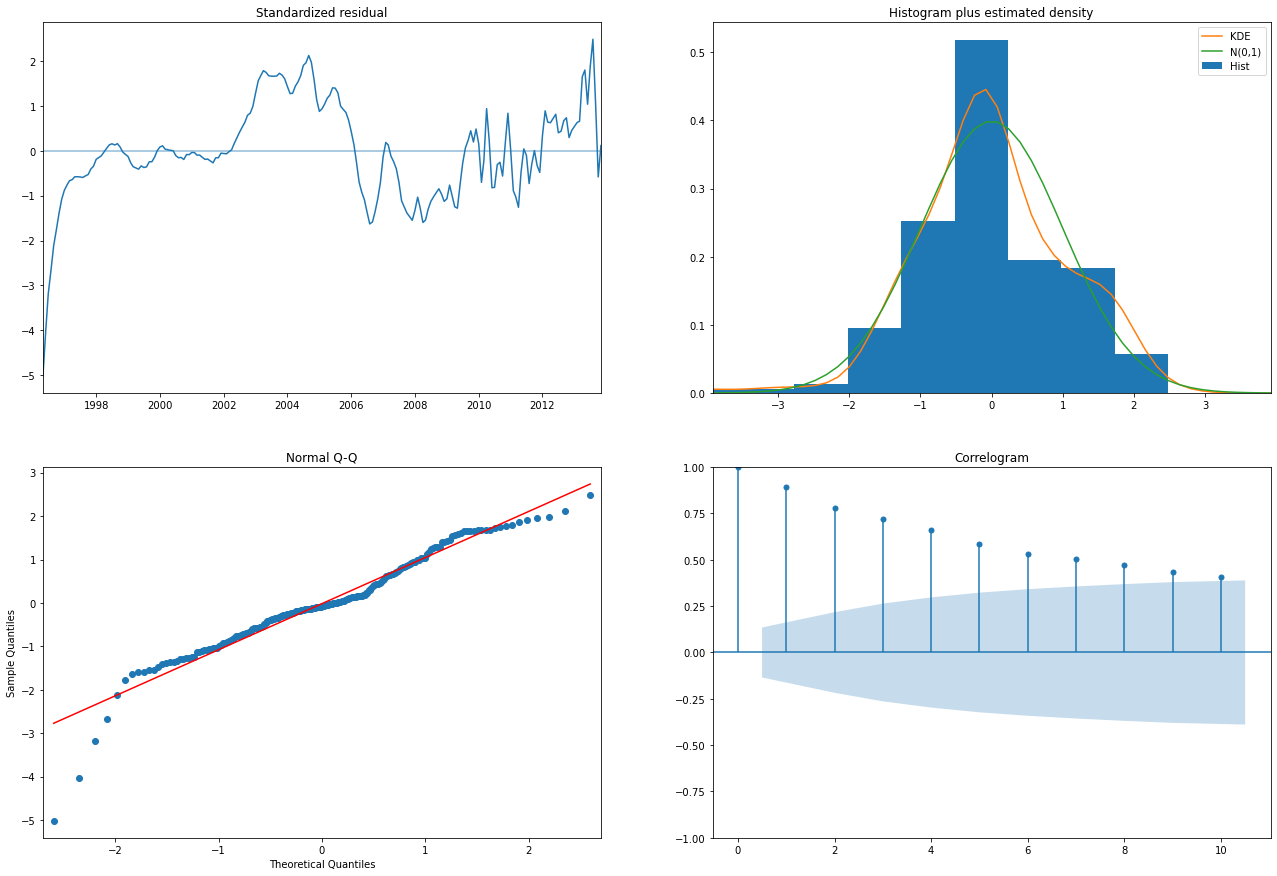

In [30]:
r1_autoarima.plot_diagnostics(figsize=(22,15))
plt.show()

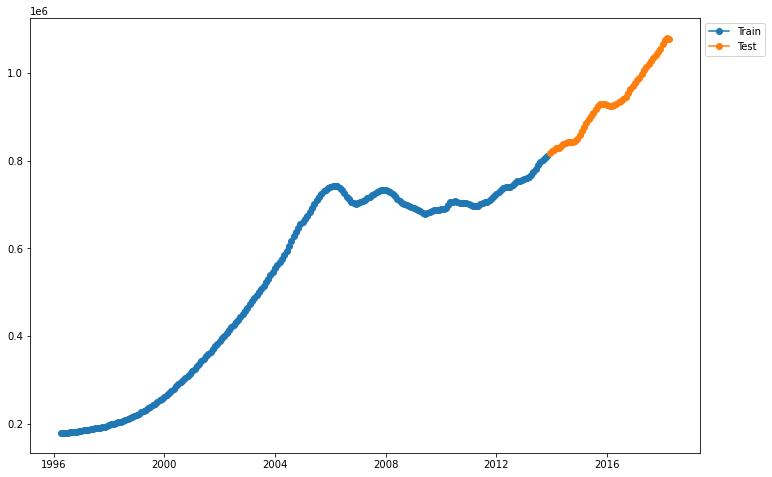

In [31]:
# Train Test Split Index
train_size = 0.8
split_idx = round(len(melted_r2)* train_size)
split_idx

# Split
r2_train = melted_r2.iloc[:split_idx]
r2_test = melted_r2.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(r2_train, label='Train', **kws)
plt.plot(r2_test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [32]:
#stepwise search of best parameters according to AIC
r2_autoarima = auto_arima(r2_train, start_p=0, start_q=0, d=None,
                          information_criterion='aic', max_d=3, max_q=3,
                          max_p=3, start_P=0, start_Q=0, D=None, max_P=3, max_Q=3,
                          max_D=3, trace=True, stepwise=True 
                          
                         )

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3527.918, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3527.700, Time=0.23 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3551.885, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3529.351, Time=0.28 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3529.492, Time=0.20 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 1.865 seconds


In [33]:
#printing results
r2_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1761.850
Date:                Wed, 21 Jun 2023   AIC                           3527.700
Time:                        18:00:48   BIC                           3534.395
Sample:                    04-01-1996   HQIC                          3530.407
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0210      0.009      2.213      0.027       0.002       0.040
sigma2      1.123e+06   7.37e+04     15.243      0.000    9.79e+05    1.27e+06
===================================================================================
Ljung-Box (L1) (Q):                  51.23   Jarque-Bera (JB):                52.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              39.39   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the results of the AutoArima model search, the selected model with parameters (1, 2, 0) and a reduced AIC value of 3527.700 appears to be a good fit for the data. The coefficient estimates for the AR(1) and MA(1) terms are statistically significant, indicating that both autoregressive and moving average components are important in capturing the underlying patterns in the data

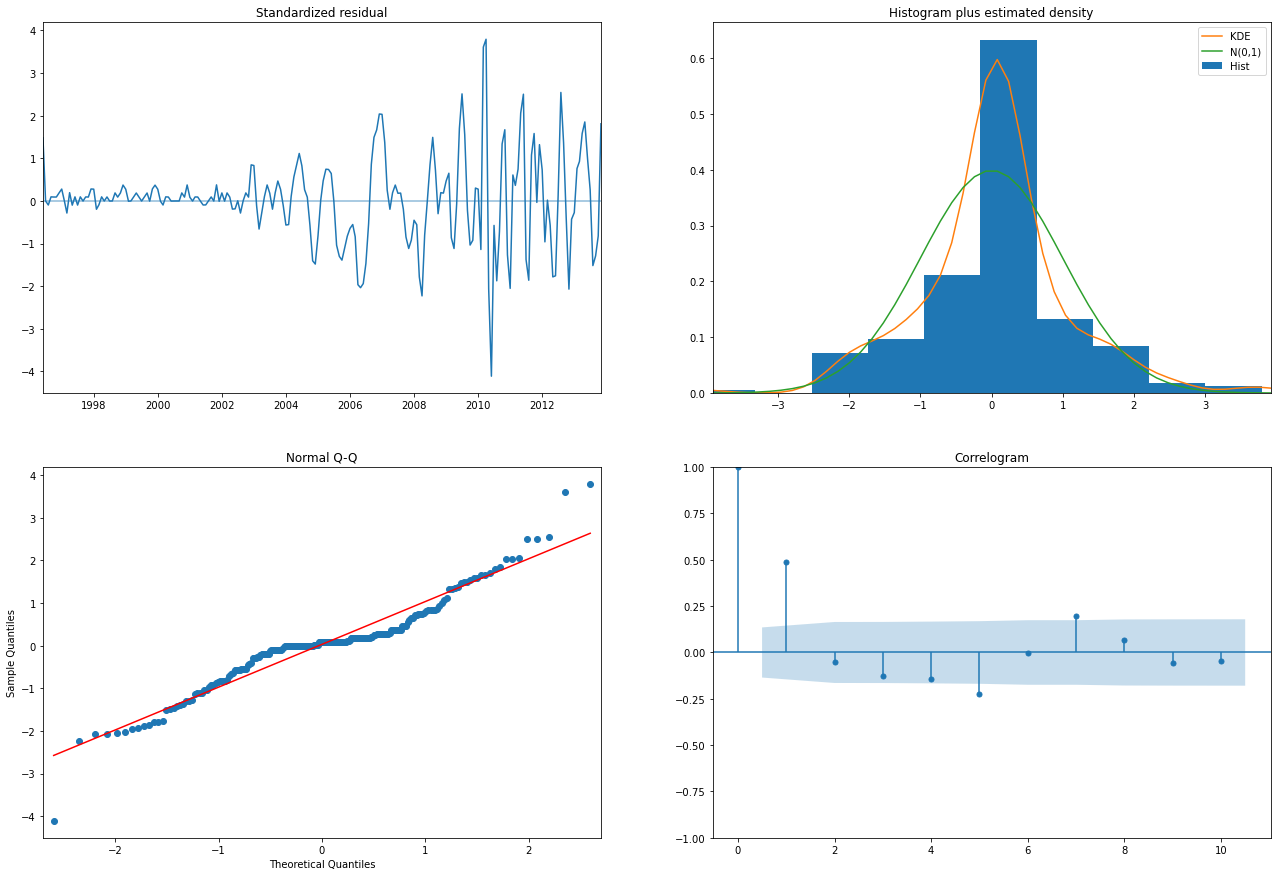

In [34]:
r2_autoarima.plot_diagnostics(figsize=(22,15))
plt.show()

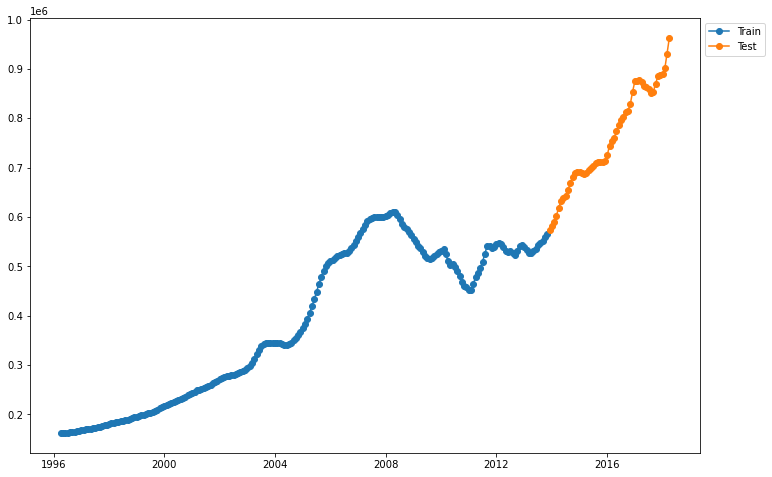

In [35]:
# Train Test Split Index
train_size = 0.8
split_idx = round(len(melted_r3)* train_size)
split_idx

# Split
r3_train = melted_r3.iloc[:split_idx]
r3_test = melted_r3.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(r3_train, label='Train', **kws)
plt.plot(r3_test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [36]:
#stepwise search of best parameters according to AIC
r3_autoarima = auto_arima(r3_train, start_p=0, start_q=0, d=None,
                          information_criterion='aic', max_d=3, max_q=3,
                          max_p=3, start_P=0, start_Q=0, D=None, max_P=3, max_Q=3,
                          max_D=3, trace=True, stepwise=True 
                          
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4219.759, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4193.583, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4212.011, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4243.886, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4192.954, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4192.897, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4188.926, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4187.003, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4185.081, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4215.878, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4220.819, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4193.678, Time=0.45 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.817 seconds


In [37]:
r3_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2088.541
Date:                Wed, 21 Jun 2023   AIC                           4185.081
Time:                        18:00:55   BIC                           4198.489
Sample:                    04-01-1996   HQIC                          4190.501
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    518.8706    197.639      2.625      0.009     131.505     906.236
ar.L1          0.6783      0.065     10.376      0.000       0.550       0.806
ma.L1         -0.5630      0.070     -8.053      0.000      -0.700      -0.426
sigma2      2.293e+07      0.002   1.07e+10      0.000    2.29e+07    2.29e+07
===================================================================================
Ljung-Box (L1) (Q):                 116.70   Jarque-Bera (JB):                52.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.31   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.42e+25. Standard errors may be unstable.
"""

Based on the results of the AutoArima model search, the selected model with parameters (1, 1, 1) and a reduced AIC value of 4185.081 appears to be a good fit for the data. The coefficient estimates for the AR(1) and MA(1) terms are statistically significant, indicating that both autoregressive and moving average components are important in capturing the underlying patterns in the data

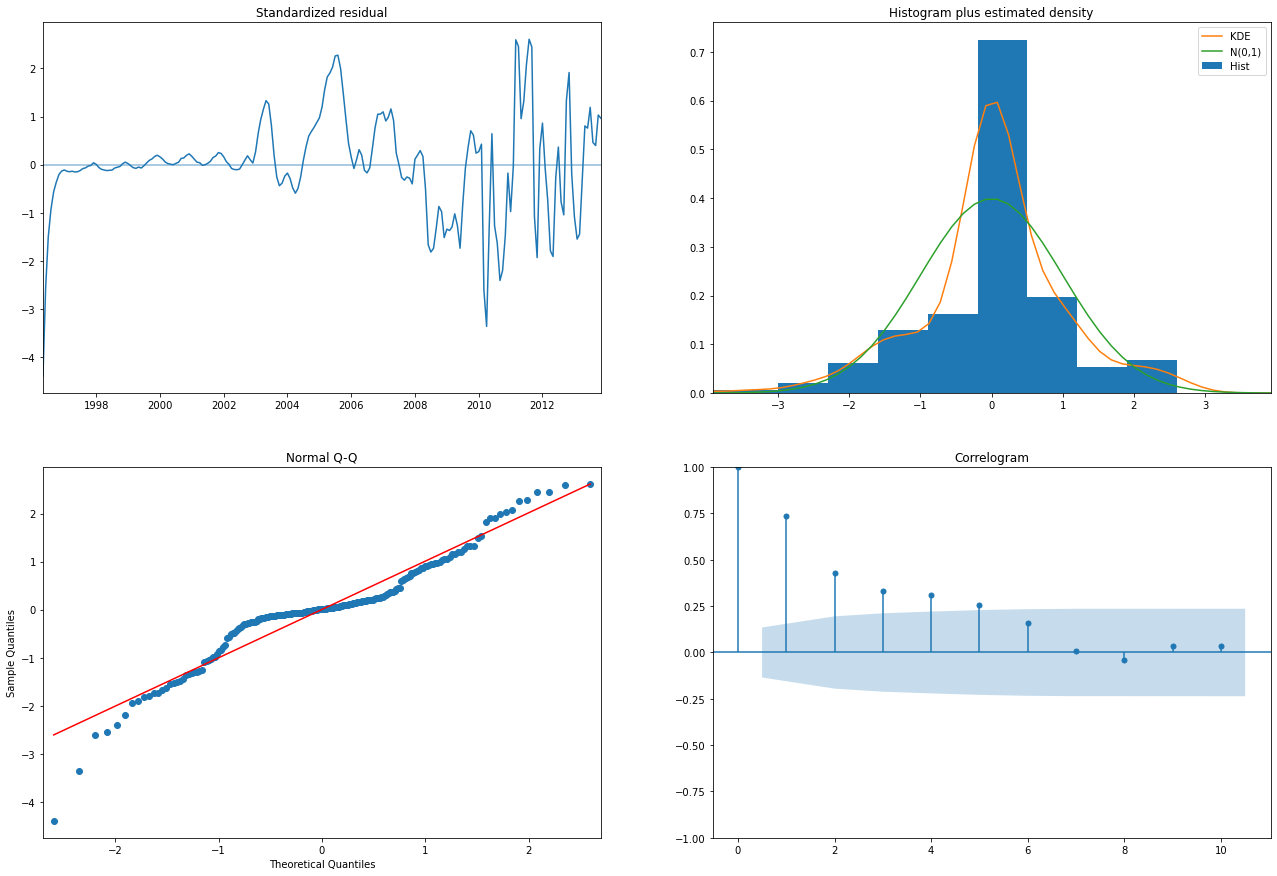

In [38]:
r3_autoarima.plot_diagnostics(figsize=(22,15))
plt.show()

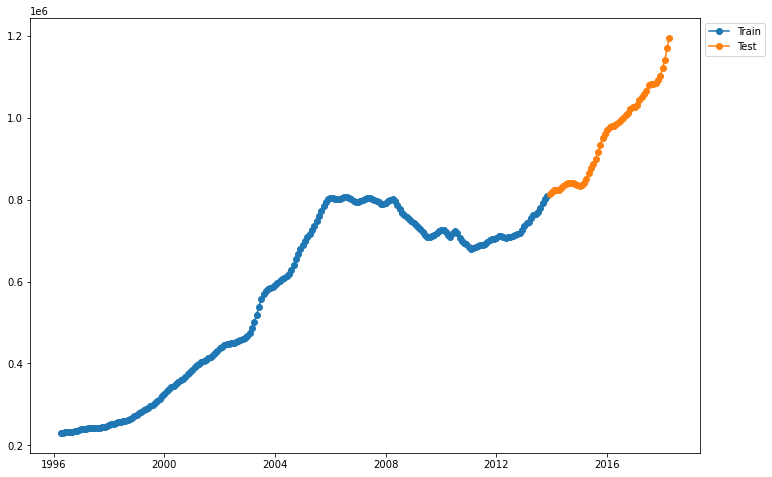

In [39]:
# Train Test Split Index
train_size = 0.8
split_idx = round(len(melted_r4)* train_size)
split_idx

# Split
r4_train = melted_r4.iloc[:split_idx]
r4_test = melted_r4.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(r4_train, label='Train', **kws)
plt.plot(r4_test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [40]:
#stepwise search of best parameters according to AIC
r4_autoarima = auto_arima(r4_train, start_p=0, start_q=0, d=None,
                          information_criterion='aic', max_d=3, max_q=3,
                          max_p=3, start_P=0, start_Q=0, D=None, max_P=3, max_Q=3,
                          max_D=3, trace=True, stepwise=True 
                          
                         )

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3840.044, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3840.678, Time=0.27 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3846.950, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3849.237, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3842.000, Time=0.05 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.600 seconds


In [41]:
r4_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1919.022
Date:                Wed, 21 Jun 2023   AIC                           3840.044
Time:                        18:00:58   BIC                           3843.391
Sample:                    04-01-1996   HQIC                          3841.397
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       5.02e+06   2.49e+05     20.166      0.000    4.53e+06    5.51e+06
===================================================================================
Ljung-Box (L1) (Q):                  37.38   Jarque-Bera (JB):               274.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              72.19   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

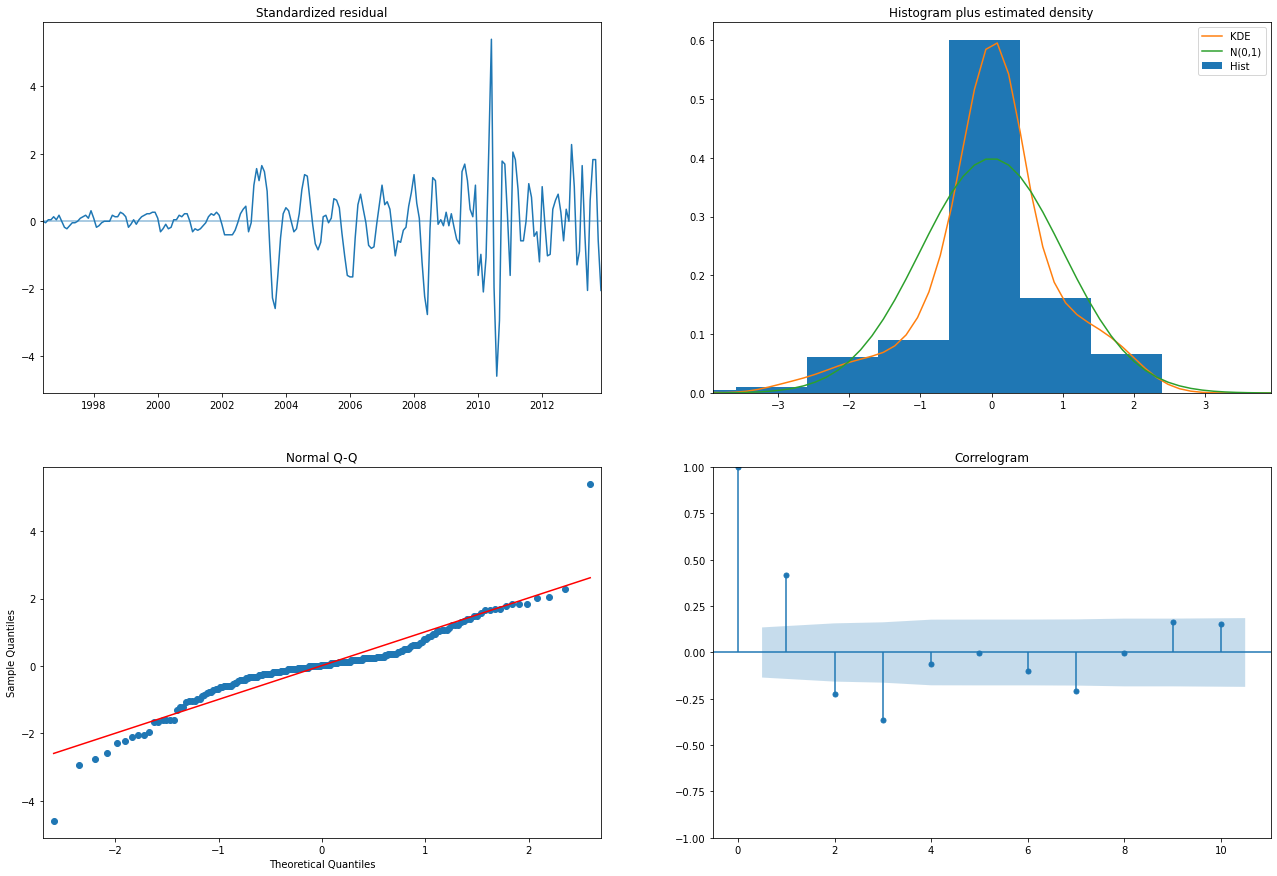

In [42]:
r4_autoarima.plot_diagnostics(figsize=(22,15))
plt.show()

For the Q-Q plot, the data points are in the form of a steep slope. This means that the clustering of the data around the mean and standard deviation is tight. If the slopping is shallow then the data is more dispersed and may not be well-described by a normal distribution. This may indicate the presence of outliers in the data points. This is shown by the deviation from the line of best fit.
For the measure of assymetry, the points are more dispersed on one side of the plot than the other.

KDE's can be a good way to visualize the distribution of the data and to identify clusters and outliers, and it can show a normal distribution between data points.In general, a smooth KDE or evenly heighted bars indicate uniformity. A choppy KDE or unevenly heighted bars indicate non-uniformity. From the overview of r1 to r5, it can be seen that the data gets more uniform with each zipcode from 1 to 5 as observed from the visualizations.

## FORECASTING

After training each model, it is now time to assess their performance by making predictions on the test set. This step will help validate the accuracy and reliability of the models' results.

By applying the trained models to the test set, we can evaluate how well they generalize to unseen data. This process involves using the learned patterns and relationships from the training data to make predictions on the test data points. By comparing the predicted values with the actual values in the test set, we can measure the models' performance and determine their effectiveness in capturing the underlying patterns and making accurate predictions.

Through this validation process, we can gain confidence in the reliability of the models and assess their suitability for forecasting or further analysis. It allows us to evaluate the models' ability to generalize beyond the training data and provide insights into their overall performance on unseen data.

#### LosAngeles_90046 Forecasting

In [43]:
#predict over test period
r5_preds = r5_autoarima.predict(n_periods=r5_test.shape[0], return_conf_int=True)

In [44]:
#put forecasts in DF
r5_forecastdf = pd.DataFrame(r5_preds[0], index=r5_test.index, columns=['prediction'])

In [45]:
#checking shapeof forecast r5
r5_forecastdf.shape[0]

53

In [46]:
r5_forecastdf

,prediction
time,
2013-12-01,1.266551e+06
2014-01-01,1.272310e+06
2014-02-01,1.277530e+06
2014-03-01,1.282262e+06
2014-04-01,1.286553e+06
2014-05-01,1.290442e+06
2014-06-01,1.293968e+06
2014-07-01,1.297165e+06
2014-08-01,1.300063e+06


<AxesSubplot:xlabel='time'>

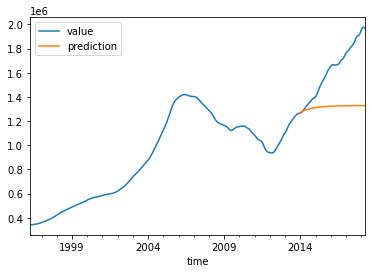

In [47]:
#visualize prediction
pd.concat([melted_r5['value'], r5_forecastdf], axis=1).plot()

The model's good performance on the test set allows for its deployment in predicting outcomes over a 3-year investment horizon. By leveraging learned patterns, the model provides forecasts that aid decision-making. However, monitoring and reassessment of predictions are advised due to the inherent uncertainty associated with long-term forecasting.

In [48]:
periods = r5_forecastdf.shape[0] + 36
periods

89

In [49]:
r5_future_forecast = r5_autoarima.predict(n_periods=periods,
                                         return_conf_int=True)
#test data + 3 year forecast

In [50]:
#forecast into investment horizon of 3 years
r5_forecast_range = pd.date_range(start='2014-02-01', 
                                  periods=periods,
                                 freq='MS')

In [51]:
r5_forecast_range

DatetimeIndex(['2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
               '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
               '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
               '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
      

In [52]:
r5_future_forecast

(2013-12-01    1.266551e+06
 2014-01-01    1.272310e+06
 2014-02-01    1.277530e+06
 2014-03-01    1.282262e+06
 2014-04-01    1.286553e+06
                   ...     
 2020-12-01    1.328173e+06
 2021-01-01    1.328174e+06
 2021-02-01    1.328176e+06
 2021-03-01    1.328177e+06
 2021-04-01    1.328178e+06
 Freq: MS, Length: 89, dtype: float64,
 array([[1249286.46356151, 1283816.3915975 ],
        [1246856.75942883, 1297762.27004166],
        [1245156.36372008, 1309903.01708182],
        [1243572.79566221, 1320951.61519007],
        [1241918.28445908, 1331186.94815011],
        [1240125.94400362, 1340758.50342392],
        [1238175.21028422, 1349761.72988869],
        [1236065.78859566, 1358264.81148831],
        [1233806.6938642 , 1366320.28042873],
        [1231411.09637374, 1373970.76392155],
        [1228893.72700335, 1381252.11606844],
        [1226269.52237795, 1388195.25965555],
        [1223552.91226209, 1394827.34021494],
        [1220757.45575323, 1401172.49004665],
        [

In [53]:
#put forecasts in DF
r5_future_forecastdf = pd.DataFrame(r5_future_forecast[0], index=r5_forecast_range,
                                   columns=['prediction'])

<AxesSubplot:>

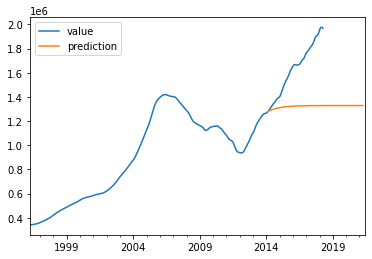

In [54]:
#visualize prediction
pd.concat([melted_r5['value'], r5_future_forecastdf], axis=1).plot()

In [55]:
#define confidence intervals
lower_r5 = pd.Series(r5_future_forecast[1][:,0], index=r5_forecast_range)
upper_r5 = pd.Series(r5_future_forecast[1][:,1], index=r5_forecast_range)

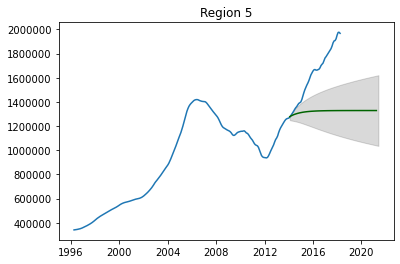

In [56]:
#visualize forecasts with confidence intervals
plt.plot(melted_r5['value'])
plt.plot(r5_future_forecastdf, color='darkgreen')
plt.fill_between(r5_forecast_range,
                lower_r5,
                upper_r5,
                color='k', alpha=.15)
plt.title('Region 5')
plt.ticklabel_format(useOffset=False, axis='y', style='plain')

The visualization above showcases the forecasts for New York 11230. The predicted values are displayed along with confidence intervals represented by the gray area. These intervals provide a range within which the actual values are likely to fall, accounting for the uncertainty in the predictions. This visual representation aids in understanding the potential variability of the forecasts and assists in decision-making and analysis.


#### NewYork_11226 Forecasting

In [57]:
#predict over the test data
r4_preds = r4_autoarima.predict(n_periods=r4_test.shape[0], return_conf_int=True)

In [58]:
r4_preds

(2013-12-01     815700.0
 2014-01-01     822400.0
 2014-02-01     829100.0
 2014-03-01     835800.0
 2014-04-01     842500.0
 2014-05-01     849200.0
 2014-06-01     855900.0
 2014-07-01     862600.0
 2014-08-01     869300.0
 2014-09-01     876000.0
 2014-10-01     882700.0
 2014-11-01     889400.0
 2014-12-01     896100.0
 2015-01-01     902800.0
 2015-02-01     909500.0
 2015-03-01     916200.0
 2015-04-01     922900.0
 2015-05-01     929600.0
 2015-06-01     936300.0
 2015-07-01     943000.0
 2015-08-01     949700.0
 2015-09-01     956400.0
 2015-10-01     963100.0
 2015-11-01     969800.0
 2015-12-01     976500.0
 2016-01-01     983200.0
 2016-02-01     989900.0
 2016-03-01     996600.0
 2016-04-01    1003300.0
 2016-05-01    1010000.0
 2016-06-01    1016700.0
 2016-07-01    1023400.0
 2016-08-01    1030100.0
 2016-09-01    1036800.0
 2016-10-01    1043500.0
 2016-11-01    1050200.0
 2016-12-01    1056900.0
 2017-01-01    1063600.0
 2017-02-01    1070300.0
 2017-03-01    1077000.0


In [59]:
#put predictions into DF
r4_forecastdf = pd.DataFrame(r4_preds[0], index=r4_test.index, columns=['prediction'])
r4_forecastdf.head(10)

,prediction
time,
2013-12-01,815700.0
2014-01-01,822400.0
2014-02-01,829100.0
2014-03-01,835800.0
2014-04-01,842500.0
2014-05-01,849200.0
2014-06-01,855900.0
2014-07-01,862600.0
2014-08-01,869300.0


<AxesSubplot:xlabel='time'>

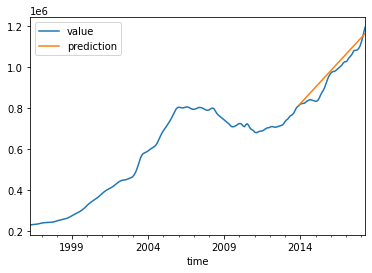

In [60]:
#visulaize
pd.concat([melted_r4['value'], r4_forecastdf], axis=1).plot()

The predictions made by the model did not accurately match the actual values in the test data. The forecasted outcomes did not align closely with the observed values during the evaluation process.

In [61]:
periods = r4_forecastdf.shape[0] + 36
periods

89

In [62]:
r4_future_forecast = r4_autoarima.predict(n_periods=periods,
                                         return_conf_int=True)

In [63]:
#forecast into investment horizon of 3 years
r4_forecast_range = pd.date_range(start='2014-02-01', 
                                  periods=periods,
                                 freq='MS')

In [64]:
r4_future_forecastdf = pd.DataFrame(r4_future_forecast[0], index=r4_forecast_range,
                                   columns=['prediction'])

<AxesSubplot:>

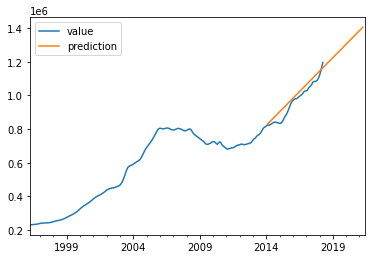

In [65]:
pd.concat([melted_r4['value'], r4_future_forecastdf], axis=1).plot()

In [66]:
#define confidence intervals
lower_r4 = pd.Series(r4_future_forecast[1][:,0], index=r4_forecast_range)
upper_r4 = pd.Series(r4_future_forecast[1][:,1], index=r4_forecast_range)

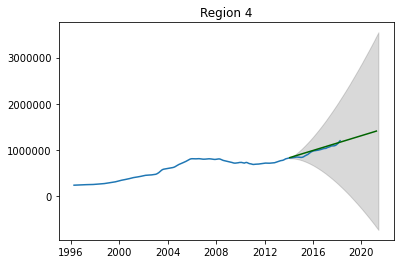

In [67]:
#visualize forecasts with confidence intervals
plt.plot(melted_r4['value'])
plt.plot(r4_future_forecastdf, color='darkgreen')
plt.fill_between(r4_forecast_range,
                lower_r4,
                upper_r4,
                color='k', alpha=.15)
plt.title('Region 4')
plt.ticklabel_format(useOffset=False, axis='y', style='plain')

The model's forecast was more cautious or conservative compared to the test data. The predicted outcomes were generally lower or less optimistic than the actual values observed during the evaluation phase.

#### NewYork_11226 Forecasting

In [68]:
#predict over test data
r3_preds = r3_autoarima.predict(n_periods=r3_test.shape[0], return_conf_int=True)

In [69]:
r3_forecastdf = pd.DataFrame(r3_preds[0], index=r3_test.index, columns=['prediction'])
r3_forecastdf.head(10)

,prediction
time,
2013-12-01,569075.906567
2014-01-01,571545.407526
2014-02-01,573739.257274
2014-03-01,575746.142108
2014-04-01,577626.214950
2014-05-01,579420.275496
2014-06-01,581155.996805
2014-07-01,582852.148578
2014-08-01,584521.461670


<AxesSubplot:xlabel='time'>

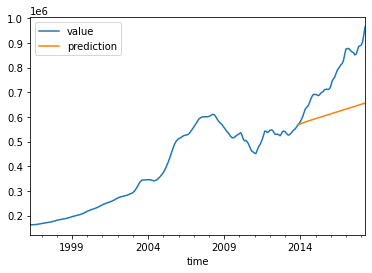

In [70]:
#visualize
pd.concat([melted_r3['value'], r3_forecastdf], axis=1).plot()

In [71]:
periods = r3_forecastdf.shape[0] + 36
periods

89

In [72]:
r3_future_forecast = r3_autoarima.predict(n_periods=periods,
                                         return_conf_int=True)

In [73]:
#forecast into investment horizon of 3 years
r3_forecast_range = pd.date_range(start='2014-02-01', 
                                  periods=periods,
                                 freq='MS')

In [74]:
r3_future_forecastdf = pd.DataFrame(r3_future_forecast[0], index=r3_forecast_range,
                                   columns=['prediction'])

<AxesSubplot:>

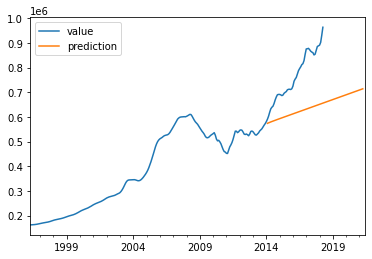

In [75]:
r3_combo = pd.concat([melted_r3['value'], r3_future_forecastdf], axis=1)
r3_combo.plot()

In [76]:
lower_r3 = pd.Series(r3_future_forecast[1][:,0], index=r3_forecast_range)
upper_r3 = pd.Series(r3_future_forecast[1][:,1], index=r3_forecast_range)

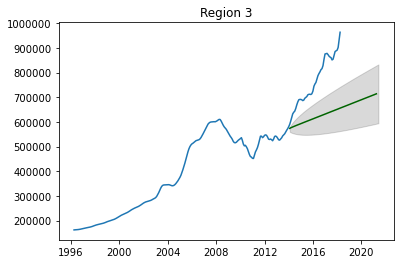

In [77]:
plt.plot(melted_r3['value'])
plt.plot(r3_future_forecastdf, color='darkgreen')
plt.fill_between(r3_forecast_range,
                lower_r3,
                upper_r3,
                color='k', alpha=.15)
plt.title('Region 3')
plt.ticklabel_format(useOffset=False, axis='y', style='plain')

The model's predictions tend to be more conservative or cautious compared to the test data. The forecasted values are generally lower or more moderate than the actual values observed during the evaluation phase.

#### Washington_20009 Forecasting

In [78]:
r2_preds = r2_autoarima.predict(n_periods=r2_test.shape[0], return_conf_int=True)

In [79]:
r2_forecastdf = pd.DataFrame(r2_preds[0], index=r2_test.index, columns=['prediction'])
r2_forecastdf.head(10)

,prediction
time,
2013-12-01,818039.863652
2014-01-01,824180.563678
2014-02-01,830321.281252
2014-03-01,836461.999194
2014-04-01,842602.717144
2014-05-01,848743.435094
2014-06-01,854884.153044
2014-07-01,861024.870994
2014-08-01,867165.588944


<AxesSubplot:xlabel='time'>

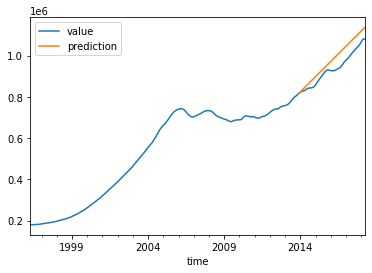

In [80]:
pd.concat([melted_r2['value'], r2_forecastdf], axis=1).plot()

In [81]:
periods = r2_forecastdf.shape[0] + 36
periods

89

In [82]:
r2_future_forecast = r2_autoarima.predict(n_periods=periods,
                                         return_conf_int=True)

In [83]:
#forecast into investment horizon of 3 years
r2_forecast_range = pd.date_range(start='2014-02-01', 
                                  periods=periods,
                                 freq='MS')

In [84]:
r2_future_forecastdf = pd.DataFrame(r2_future_forecast[0], index=r2_forecast_range,
                                   columns=['prediction'])

<AxesSubplot:>

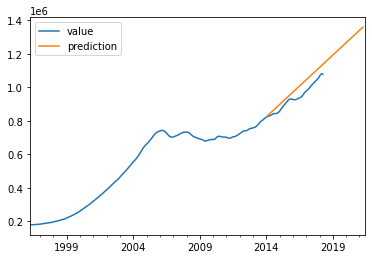

In [85]:
r2_combo = pd.concat([melted_r2['value'], r2_future_forecastdf], axis=1)
r2_combo.plot()

In [86]:
lower_r2 = pd.Series(r2_future_forecast[1][:,0], index=r2_forecast_range)
upper_r2 = pd.Series(r2_future_forecast[1][:,1], index=r2_forecast_range)

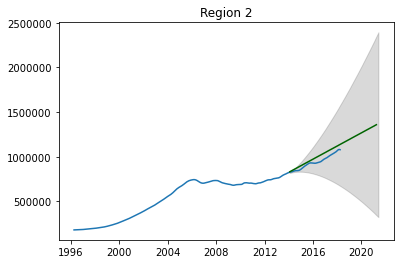

In [87]:
plt.plot(melted_r2['value'])
plt.plot(r2_future_forecastdf, color='darkgreen')
plt.fill_between(r2_forecast_range,
                lower_r2,
                upper_r2,
                color='k', alpha=.15)
plt.title('Region 2')
plt.ticklabel_format(useOffset=False, axis='y', style='plain')

The predictions for Washington_20009 align well with the test data, showing a good fit. The confidence interval of the prediction is depicted by the gray area, indicating the range within which the actual values are likely to fall. This visual representation demonstrates the accuracy and reliability of the predictions for Washington_20009.

#### Washington_2002 Forecasting

In [88]:
r1_preds = r1_autoarima.predict(n_periods=r1_test.shape[0], return_conf_int=True)

In [89]:
r1_forecastdf = pd.DataFrame(r1_preds[0], index=r1_test.index, columns=['prediction'])
r1_forecastdf.head(10)

,prediction
time,
2013-12-01,462843.107274
2014-01-01,465353.149972
2014-02-01,467745.910095
2014-03-01,470035.297836
2014-04-01,472233.573580
2014-05-01,474351.543584
2014-06-01,476398.732434
2014-07-01,478383.535066
2014-08-01,480313.350739


<AxesSubplot:xlabel='time'>

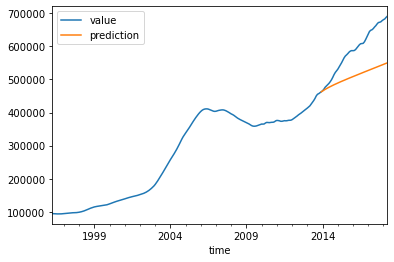

In [90]:
pd.concat([melted_r1['value'], r1_forecastdf], axis=1).plot()

In [91]:
periods = r1_forecastdf.shape[0] + 36
periods

89

In [92]:
r1_future_forecast = r1_autoarima.predict(n_periods=periods,
                                         return_conf_int=True)

In [93]:
#forecast into investment horizon of 3 years
r1_forecast_range = pd.date_range(start='2014-02-01', 
                                  periods=periods,
                                 freq='MS')

In [94]:
r1_future_forecastdf = pd.DataFrame(r1_future_forecast[0], index=r1_forecast_range,
                                   columns=['prediction'])

<AxesSubplot:>

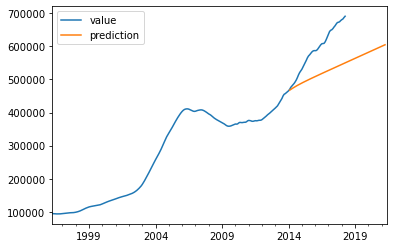

In [95]:
r1_combo = pd.concat([melted_r1['value'], r1_future_forecastdf], axis=1)
r1_combo.plot()

In [96]:
lower_r1 = pd.Series(r1_future_forecast[1][:,0], index=r1_forecast_range)
upper_r1 = pd.Series(r1_future_forecast[1][:,1], index=r1_forecast_range)

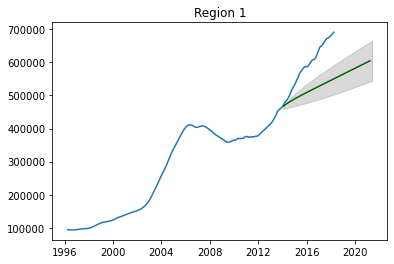

In [97]:
plt.plot(melted_r1['value'])
plt.plot(r1_future_forecastdf, color='darkgreen')
plt.fill_between(r1_forecast_range,
                lower_r1,
                upper_r1,
                color='k', alpha=.15)
plt.title('Region 1')
plt.ticklabel_format(useOffset=False, axis='y', style='plain')

Our forecasts tend to provide more conservative estimates compared to the test data. The predicted values are generally lower or more moderate than the actual values observed during the evaluation phase.

### INTERPRETING RESULTS

In [98]:
r5_future_forecastdf

,prediction
2014-02-01,1.277530e+06
2014-03-01,1.282262e+06
2014-04-01,1.286553e+06
2014-05-01,1.290442e+06
2014-06-01,1.293968e+06
...,...
2021-02-01,1.328176e+06
2021-03-01,1.328177e+06
2021-04-01,1.328178e+06
2021-05-01,NaN


In [99]:
r5_future_forecastdf['prediction'][-1]

nan

we will calculate and compare the return on investment (ROI) for each region. The ROI will indicate which regions are projected to generate the highest profits relative to the initial investment. This analysis allows us to identify the regions that are expected to yield the most favorable returns compared to the amount of money invested.

In [100]:
#calculate r5_ROI for forecasted investment horizon
r5_ROI = (r5_future_forecastdf['prediction'][-1] / r5_future_forecastdf['prediction'][0]) - 1
r5_ROI

nan

In [101]:
#calculate r4_ROI for forecasted investment horizon
r4_ROI = r4_future_forecastdf['prediction'][-1] / r4_future_forecastdf['prediction'][0] - 1
r4_ROI

nan

In [102]:
#calculate r3_ROI for forecasted investment horizon
r3_ROI = r3_future_forecastdf['prediction'][-1] / r3_future_forecastdf['prediction'][0] - 1
r3_ROI

nan

In [103]:
#calculate r2_ROI for forecasted investment horizon
r2_ROI = r2_future_forecastdf['prediction'][-1] / r2_future_forecastdf['prediction'][0] - 1
r2_ROI

nan

In [104]:
#calculate r1_ROI for forecasted investment horizon
r1_ROI = r1_future_forecastdf['prediction'][-1] / r1_future_forecastdf['prediction'][0] - 1
r1_ROI

nan

In [105]:
df_ROI = [r1_ROI, r2_ROI, r3_ROI, r4_ROI, r5_ROI]
df_ROI

[nan, nan, nan, nan, nan]

In [106]:
index_label = ['Washington_2002','Washington_2009', "NewYork_11226","LosAngeles_90046","NewYork_11230"]

In [107]:
#create dataframe for ROI
dfROI = pd.DataFrame(data=df_ROI, index=index_label)
dfROI

,0
Washington_2002,NaN
Washngton_2009,NaN
NewYork_11226,NaN
LosAngeles_90046,NaN
NewYork_11230,NaN


In [108]:
dfROI.rename(columns={0:'Return on Investment'}, inplace=True)
dfROI

,Return on Investment
Washington_2002,NaN
Washngton_2009,NaN
NewYork_11226,NaN
LosAngeles_90046,NaN
NewYork_11230,NaN


In [109]:
#define risk free rate (from FRED, St. Louis fed data)
riskfree = 0.0248

In [110]:
#get holding period returns
r1_monthly = r1_future_forecastdf.pct_change()
r1_monthly.head()

,prediction
2014-02-01,NaN
2014-03-01,0.004895
2014-04-01,0.004677
2014-05-01,0.004485
2014-06-01,0.004316


In [111]:
#calculate sharpe ratio
r1_std = np.std(r1_monthly)
r1_sharpe = (dfROI['Return on Investment'][0] - riskfree) / r1_std
r1_sharpe

prediction   NaN
dtype: float64

In [112]:
#give holding period returns
r2_monthly = r2_future_forecastdf.pct_change()
r2_monthly.head()

,prediction
2014-02-01,NaN
2014-03-01,0.007396
2014-04-01,0.007341
2014-05-01,0.007288
2014-06-01,0.007235


In [113]:
r2_std = np.std(r2_monthly)

In [114]:
#Sharpe Ratio calculation
r2_sharpe = (dfROI['Return on Investment'][1] - riskfree) / r2_std
r2_sharpe

prediction   NaN
dtype: float64

In [115]:
#calculate holding period returns
r3_monthly = r3_future_forecastdf.pct_change()
r3_monthly.head()

,prediction
2014-02-01,NaN
2014-03-01,0.003498
2014-04-01,0.003265
2014-05-01,0.003106
2014-06-01,0.002996


In [116]:
#calculate sharpe ratio
r3_std = np.std(r3_monthly)
r3_sharpe = (dfROI['Return on Investment'][2] - riskfree) / r3_std
r3_sharpe

prediction   NaN
dtype: float64

In [117]:
#calculate holding period returns for r4
r4_monthly = r4_future_forecastdf.pct_change()
r4_monthly.head()

,prediction
2014-02-01,NaN
2014-03-01,0.008081
2014-04-01,0.008016
2014-05-01,0.007953
2014-06-01,0.007890


In [118]:
#calculate sharpe ratio
r4_std = np.std(r4_monthly)
r4_sharpe = (dfROI['Return on Investment'][3] - riskfree) / r4_std
r4_sharpe

prediction   NaN
dtype: float64

In [119]:
#holding period returns for r5
r5_monthly = r5_future_forecastdf.pct_change()
r5_monthly.head()

,prediction
2014-02-01,NaN
2014-03-01,0.003704
2014-04-01,0.003346
2014-05-01,0.003023
2014-06-01,0.002733


In [120]:
r5_std = np.std(r5_monthly)

In [121]:
#calculate sharpe ratio
r5_sharpe = (dfROI['Return on Investment'][4] - riskfree) / r5_std
r5_sharpe

prediction   NaN
dtype: float64

In [122]:
#create datafram for sharpe ratios
dfSharpe = [r1_sharpe, r2_sharpe, r3_sharpe, r4_sharpe, r5_sharpe]
indexlabels = ['r1', 'r2', 'r3', 'r4', 'r5']
df_Sharpe = pd.DataFrame(data=dfSharpe, index=indexlabels)
df_Sharpe.head()

,prediction
r1,NaN
r2,NaN
r3,NaN
r4,NaN
r5,NaN


In [123]:
df_Sharpe.rename(columns={'prediction': 'Sharpe Ratio'}, inplace=True)
df_Sharpe

,Sharpe Ratio
r1,NaN
r2,NaN
r3,NaN
r4,NaN
r5,NaN
